In [1]:
import os
import sys
from collections import OrderedDict, defaultdict

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, scale

# from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
# from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene


def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax


fsize = 15

base_figure_path = "figures"


alpha = 0.33

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
cividis = matplotlib.cm.get_cmap("cividis")
colors = {"cell": cividis(0.01), "gene": cividis(0.5), "mono": cividis(0.99)}

In [3]:
mtx_labels = [
    "raw",
    "pf",
    "log",
    "pf_log",
    "pf_log_pf",
    "cpm_log",
    "cp10k_log",
    "sqrt",
    "sctransform_cc",
]
# labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']
labels = [
    "raw",
    "PF",
    "sqrt",
    "log1p",
    "log1pCP10k",
    "log1pCPM",
    "scalelog1pCP10k",
    "sctransform",
    "log1pPF",
    "PFlog1pPF",
    "sctransform_cc",
]
txlabel = {
    "raw": "raw",
    "pf": "PF",
    "sqrt": "sqrt",
    "log": "log1p",
    "cp10k_log": "log1pCP10k",
    "cpm_log": "log1pCPM",
    "cp10k_log_scale": "scalelog1pCP10k",
    "sctransform": "sctransform",
    "pf_log": "log1pPF",
    "pf_log_pf": "PFlog1pPF",
    "sctransform_cc": "sctransform_cc",
}


def read_data(base_data_fn):
    data = {}

    for title in mtx_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[txlabel[title]] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values
    return data

In [4]:
ds = "angelidis_2019"
out_prefix = os.path.join("synchromesh/data/", ds, "corrected_counts")

In [5]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform_cc
loading sctransform
loading cp10k_log_scale
CPU times: user 12min 24s, sys: 22.3 s, total: 12min 46s
Wall time: 12min 43s


In [6]:
bcs = pd.read_csv(
    os.path.join(out_prefix, "metadata_barcodes.txt.gz"),
    compression="gzip",
    index_col=0,
)
assignments = bcs.celltype.values

genes = pd.read_csv(
    os.path.join(out_prefix, "raw_genes.txt.gz"), compression="gzip", header=None
).values.ravel()

In [7]:
# cell types

celltypes = ["Type_2_pneumocytes", "Alveolar_macrophage", "Ciliated_cells"]
ct_masks = [assignments == i for i in celltypes]

In [8]:
ct = celltypes[0]
ct_mask = ct_masks[0]

In [9]:
ct

'Type_2_pneumocytes'

# Mono

In [36]:
def pairwise_spearman(X, mn=0):
    # break ties
    mns = np.random.uniform(-mn / 4, mn / 4, size=X.shape[1])
    X = X.astype(float) + mns
    corr = stats.spearmanr(X, axis=1).correlation
    corr = corr[np.triu_indices(corr.shape[0], k=1)]
    return corr


def get_min_diff(matrix):
    x = matrix.flatten()
    xs = np.sort(x)
    b = xs[0]
    mn = 1100.0
    for i in range(1, xs.shape[0]):
        a = xs[i]
        if a == b:
            continue

        diff = abs(a - b)
        if diff < mn and diff > 0:
            mn = diff
        b = a
    return mn

In [37]:
%%time
mins = {}
for l in labels:
    mins[l] = get_min_diff(data[l])

CPU times: user 7min 48s, sys: 30.5 s, total: 8min 19s
Wall time: 8min 19s


## Pairwise

In [38]:
%%time
ct_sp = defaultdict(dict)
for c, c_mask in zip(celltypes, ct_masks):
    print(c)
    l = data["raw"][c_mask].sum(0)
    downsample_genes = l > 0
    for l in labels:
        print(l)
        mtx = data[l]
        X = mtx[ct_mask][:, downsample_genes]
        ct_sp[l][c] = pairwise_spearman(X, mn=mins[l])

Type_2_pneumocytes
raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc
Alveolar_macrophage
raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc
Ciliated_cells
raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc
CPU times: user 23min 10s, sys: 4min 14s, total: 27min 25s
Wall time: 7min 4s


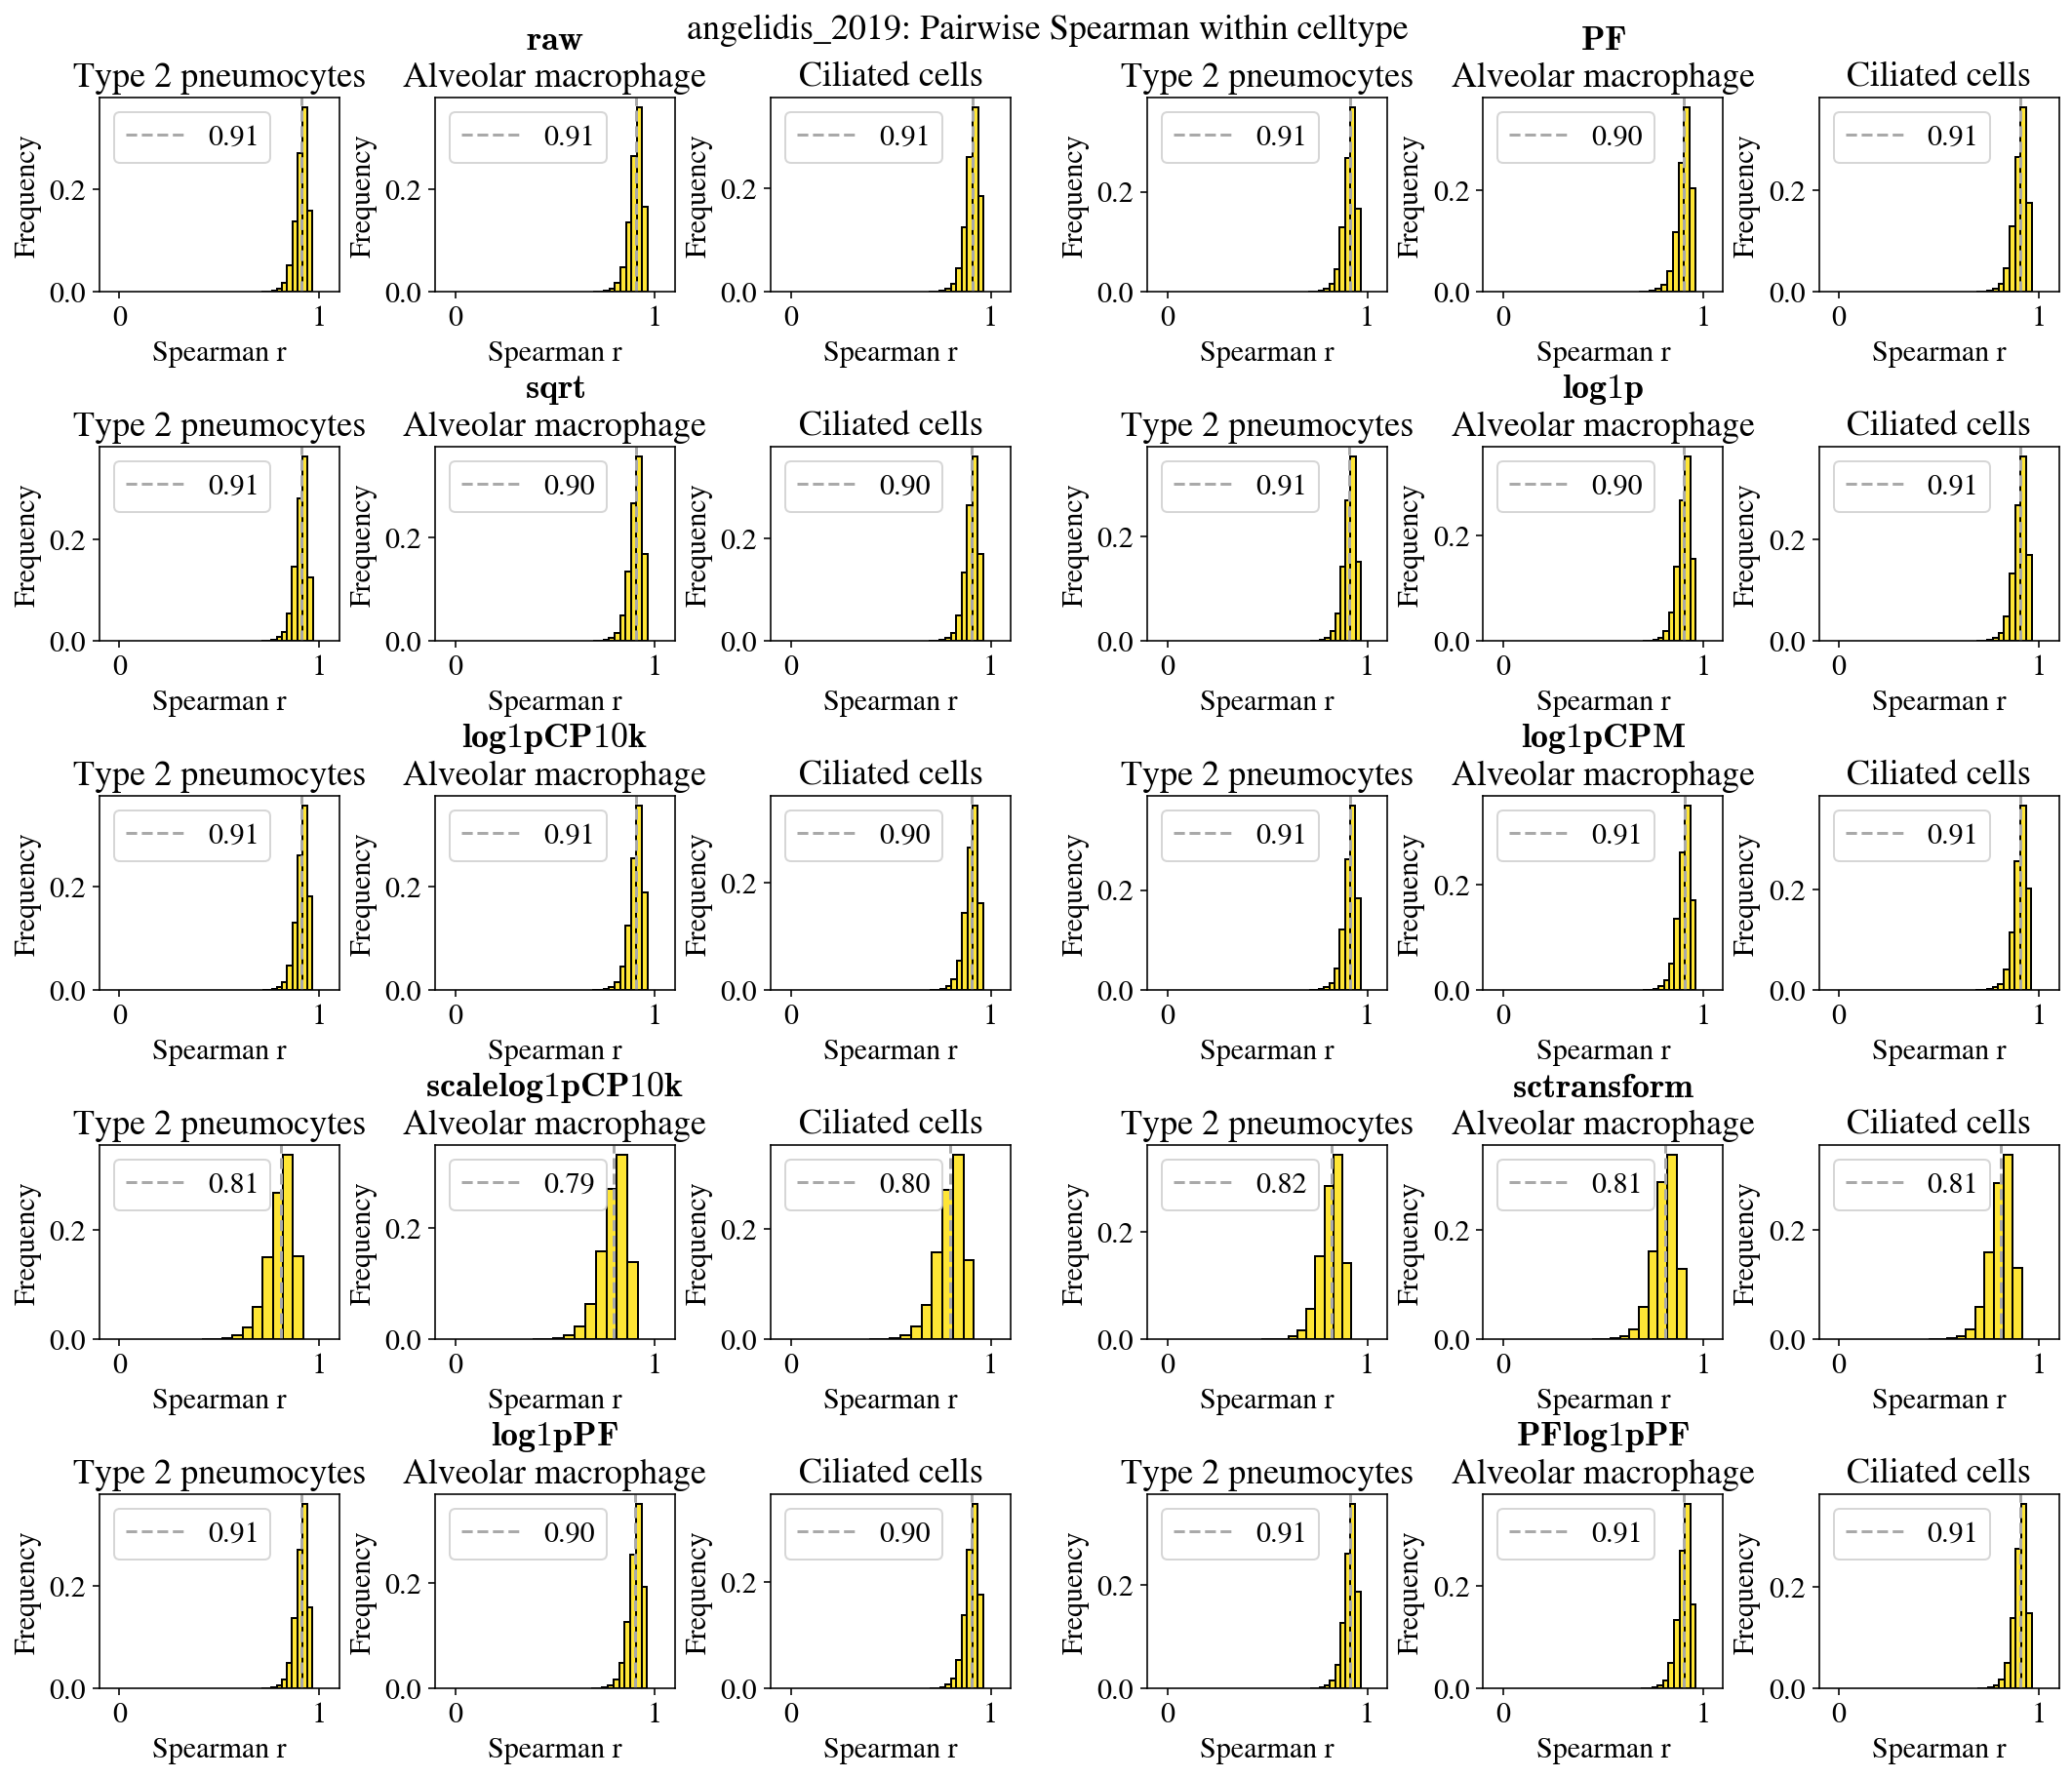

In [39]:
fig = plt.figure(figsize=(6 * 3, 5 * 3))
fig.suptitle(f"{ds}: Pairwise Spearman within celltype", y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.15, hspace=0.8)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i, j].subgridspec(1, 3, wspace=0.4)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        ax3 = fig.add_subplot(ig[0, 2])
        axs.append((ax1, ax2, ax3))

minlim = -0.1
maxlim = 1.1

p = {"xlabel": "Spearman r", "ylabel": "Frequency", "xlim": (minlim, maxlim)}

for ax, title in zip(axs, labels):
    for idx, (a, c) in enumerate(zip(ax, celltypes)):
        x = ct_sp[title][c]

        c = " ".join(c.split("_"))

        weights = np.ones(len(x)) / len(x)
        a.hist(x, weights=weights, facecolor=colors["mono"], edgecolor="k")
        a.axvline(x.mean(), color="darkgray", linestyle="--", label=f"{x.mean():,.2f}")
        p.update({"title": c})
        if idx == 1:
            p.update({"title": fr"$\bf{title}$" + f"\n{c}"})

        a.set(**p)
        a.legend()
# fig.savefig(f"{ds}_celltype_pairwise_spearman.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

base_file_name = "angelidis_2019-pairwise_spearman_within_celltype-hist"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

In [40]:
ct_metrics = defaultdict(dict)

In [41]:
# celltype specific metrics
# This will be on Alveolar macrophages

for k, v in ct_sp.items():
    for m, s in v.items():
        ct_metrics[k]["ct_spearman"] = s.mean()

# Heatmaps

In [10]:
# @title mx diff

import logging

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S")

import numpy as np
from statsmodels.stats.multitest import multipletests


def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment

    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features)
    """

    if axis == 0 and len(targets) != mat.shape[axis]:
        return -1
    if axis == 1 and len(targets) != mat.shape[axis]:
        return -1

    mask = targets == target

    if axis == 0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask]  # complement matrix
    elif axis == 1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask]  # complement matrix

    return (t_mat, c_mat)


def correct_pval(pval, nfeat, method):
    if method == "bonferroni":
        pval_corr = np.minimum(pval * nfeat[:, None], 1.0)
    return pval_corr


def nd(arr):
    return np.asarray(arr).reshape(-1)


def correct_pvals(pvals):
    r = np.empty(np.shape(pvals))
    r[:] = np.nan
    for pidx, p in enumerate(pvals):
        mask = ~np.isnan(p)

    return r


def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)

    unique = np.unique(assignments)

    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]

    pval = np.empty((nuniq, nfeat))  # unique assignments by features
    pval_corr = np.empty((nuniq, nfeat))  # unique assignments by features
    stat = np.empty((nuniq, nfeat))  # unique assignments by features
    es = np.empty((nuniq, nfeat))  # unique assignments by features
    nfeatures = np.empty((nuniq))

    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    es.fill(np.nan)
    nfeatures.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx + 1, nuniq, t))

        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)

        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray(
            (t_mat > 0).sum(axis=0) > nan_cutoff * t_mat.shape[0]
        ).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum() > 0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
            nfeatures[tidx] = mask.sum()

        pval[tidx, :][mask] = pvalue
        stat[tidx, :][mask] = statistic
        es[tidx, :][mask] = effect_size
    return (pval, stat, es, nfeatures)


def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["name", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["name"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    markers = markers.rename(columns={"index": "group_id"})
    return markers


def diff(mat, components, features, assignments):

    unique = np.unique(assignments)
    nan_cutoff = 0.1  # of elements in cluster
    corr_method = "bonferroni"

    p_raw, stat, es, nfeat = dexpress(
        mat, components, features, assignments, nan_cutoff=nan_cutoff
    )
    p_raw = p_raw / 2
    p_corr = correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    # markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [11]:
dropna = pd.notna(assignments)

In [12]:
mg = diff(data["PF"][dropna], bcs.index.values[dropna], genes, assignments[dropna])

17-Apr-22 14:59:43 - 1 of 33 assignments: Alveolar_macrophage
17-Apr-22 14:59:45 - 2 of 33 assignments: B_cells
17-Apr-22 14:59:46 - 3 of 33 assignments: CD209+/Cd11b+_dendritic_cells
17-Apr-22 14:59:47 - 4 of 33 assignments: CD8+_T_cells
17-Apr-22 14:59:47 - 5 of 33 assignments: Capillary_endothelial_cells
17-Apr-22 14:59:48 - 6 of 33 assignments: Ccl17+/Cd103-/Cd11b-_dendritic_cells
17-Apr-22 14:59:49 - 7 of 33 assignments: Cd103+/Cd11b-_dendritic_cells
17-Apr-22 14:59:50 - 8 of 33 assignments: Cd4+_T_cells
17-Apr-22 14:59:51 - 9 of 33 assignments: Ciliated_cells
17-Apr-22 14:59:52 - 10 of 33 assignments: Club_cells
17-Apr-22 14:59:53 - 11 of 33 assignments: Eosinophils
17-Apr-22 14:59:54 - 12 of 33 assignments: Fn1+_macrophage
17-Apr-22 14:59:55 - 13 of 33 assignments: Gamma-Delta_T_cells
17-Apr-22 14:59:56 - 14 of 33 assignments: Goblet_cells
17-Apr-22 14:59:57 - 15 of 33 assignments: Interstitial_Fibroblast
17-Apr-22 14:59:58 - 16 of 33 assignments: Interstitial_macrophages
17-Apr

In [13]:
markers = mg.query("es > 1 & p_corr < 0.01").sort_values("es", ascending=False)

markers = markers[~markers["name"].duplicated()].groupby("group_id").head(3)

mgenes = markers.sort_values("group_id")["name"]

In [14]:
%%time
heat = defaultdict(dict)
# average expression for each celltype

for title in labels:
    print(title)
    g = scale(data[title])
    c = scale(data[title], axis=1)

    df = pd.DataFrame(g, index=assignments)[dropna].sort_index()
    gg = df.groupby(df.index.get_level_values(0)).mean()
    asn = gg.index.values
    heat[title]["gene"] = df.values

    df = pd.DataFrame(c, index=assignments)[dropna].sort_index()
    gg = df.groupby(df.index.get_level_values(0)).mean()
    asn = gg.index.values
    heat[title]["cell"] = df.values

raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc
CPU times: user 4min 19s, sys: 2min, total: 6min 19s
Wall time: 6min 19s


In [15]:
%%time
gb = defaultdict()
# average expression for each celltype

for title in labels:
    print(title)
    m = data[title]

    df = pd.DataFrame(m, index=assignments)[dropna].sort_index()
    gg = df.groupby(df.index.get_level_values(0)).mean()
    asn = gg.index.values
    gb[title] = gg.values

raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc
CPU times: user 24.7 s, sys: 19.6 s, total: 44.3 s
Wall time: 44.3 s


In [16]:
pd.Series(assignments).value_counts()

Type_2_pneumocytes                      4199
Alveolar_macrophage                     1704
Ciliated_cells                           883
B_cells                                  855
Club_cells                               772
vascular_endothelial_cells               631
CD8+_T_cells                             612
Cd4+_T_cells                             591
low_quality_cells                        495
Interstitial_macrophages                 411
Cd103+/Cd11b-_dendritic_cells            319
non-classical_monocyte_(Ly6c2-)          312
Goblet_cells                             283
Mesothelial_cells                        279
Eosinophils                              265
Vcam1+_endothelial_cells                 217
Mki67+_proliferating_cells               217
CD209+/Cd11b+_dendritic_cells            216
Capillary_endothelial_cells              210
classical_monocyte_(Ly6c2+)              195
Natural_Killer_cells                     189
red_blood_cells                          184
Plasma_cel

## z-score genes

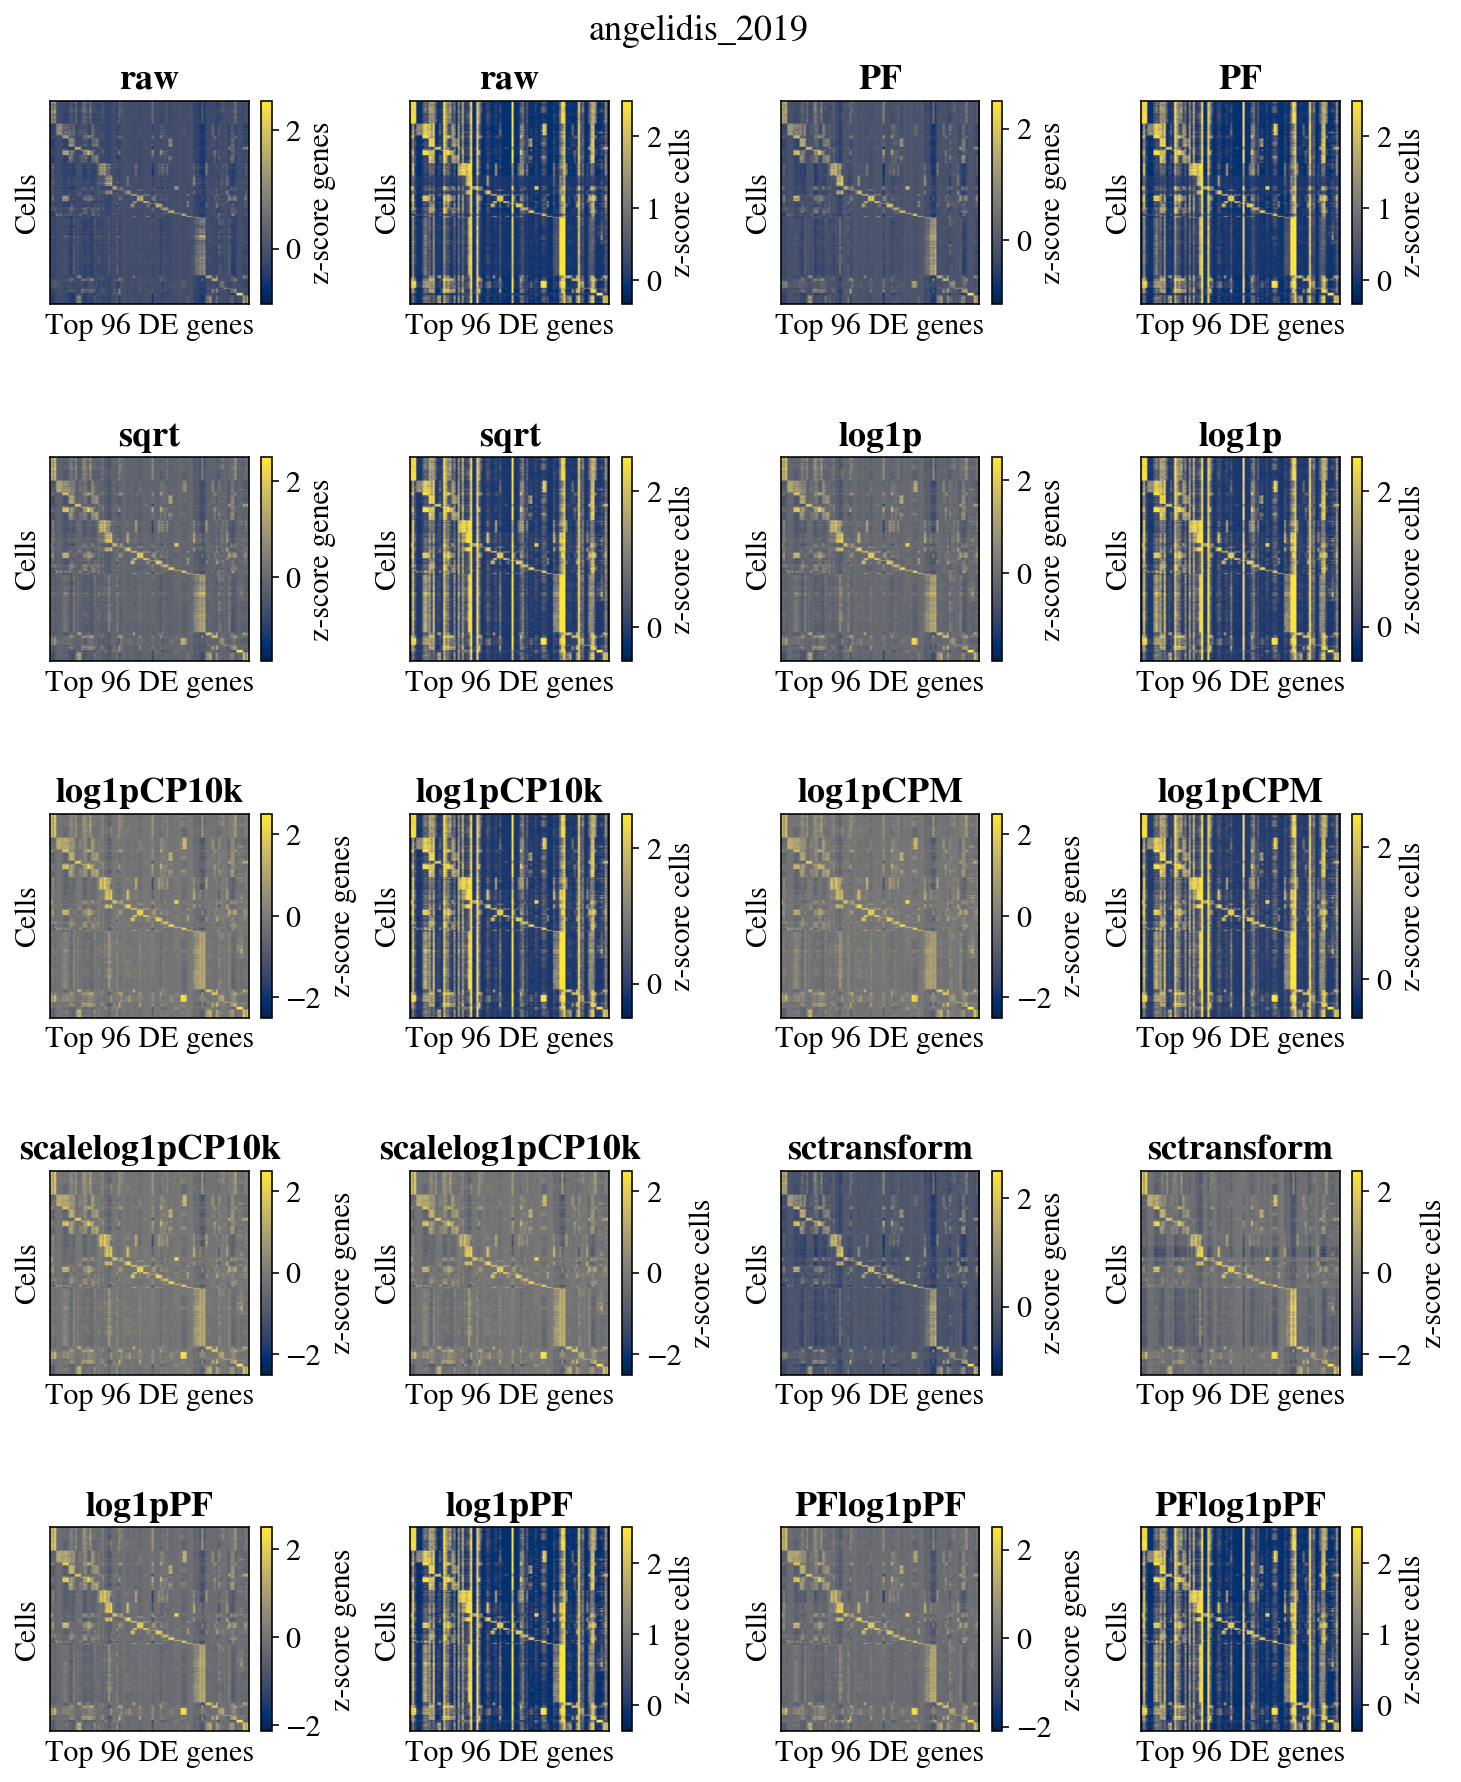

In [17]:
fig = plt.figure(figsize=(4 * 3, 5 * 3))
fig.suptitle(ds, y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.2, hspace=0.75)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i, j].subgridspec(1, 2, wspace=0.45)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        axs.append((ax1, ax2))

mgenes_idx = [list(genes).index(i) for i in mgenes]

p = {
    "ylabel": "Cells",
    "xlabel": f"Top {len(mgenes_idx)} DE genes",
    "xticks": [],
    "xticklabels": [],
    "yticks": [],
    "yticklabels": [],
}


clip = 2.5
for (ax1, ax2), title in zip(axs, labels):
    method = title

    # every cell type across all genes
    m1 = heat[method]["gene"][:, mgenes_idx]

    # clipping for consistency
    m1[m1 > clip] = clip
    m1[m1 < -clip] = -clip

    m2 = heat[method]["cell"][:, mgenes_idx]

    m2[m2 > clip] = clip
    m2[m2 < -clip] = -clip

    im1 = ax1.imshow(m1, aspect="auto", cmap="cividis")
    im2 = ax2.imshow(m2, aspect="auto", cmap="cividis")

    ax1.set(**p)
    ax1.set_title(method, weight="bold")
    cbar1 = fig.colorbar(im1, ax=ax1, shrink=1, label="z-score genes")

    p.update({"title": f"{method}"})

    ax2.set(**p)
    ax2.set_title(method, weight="bold")

    cbar = fig.colorbar(im2, ax=ax2, shrink=1, label="z-score cells")


base_file_name = "angelidis_2019-marker_gene_scale_gene_cell-heatmap"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

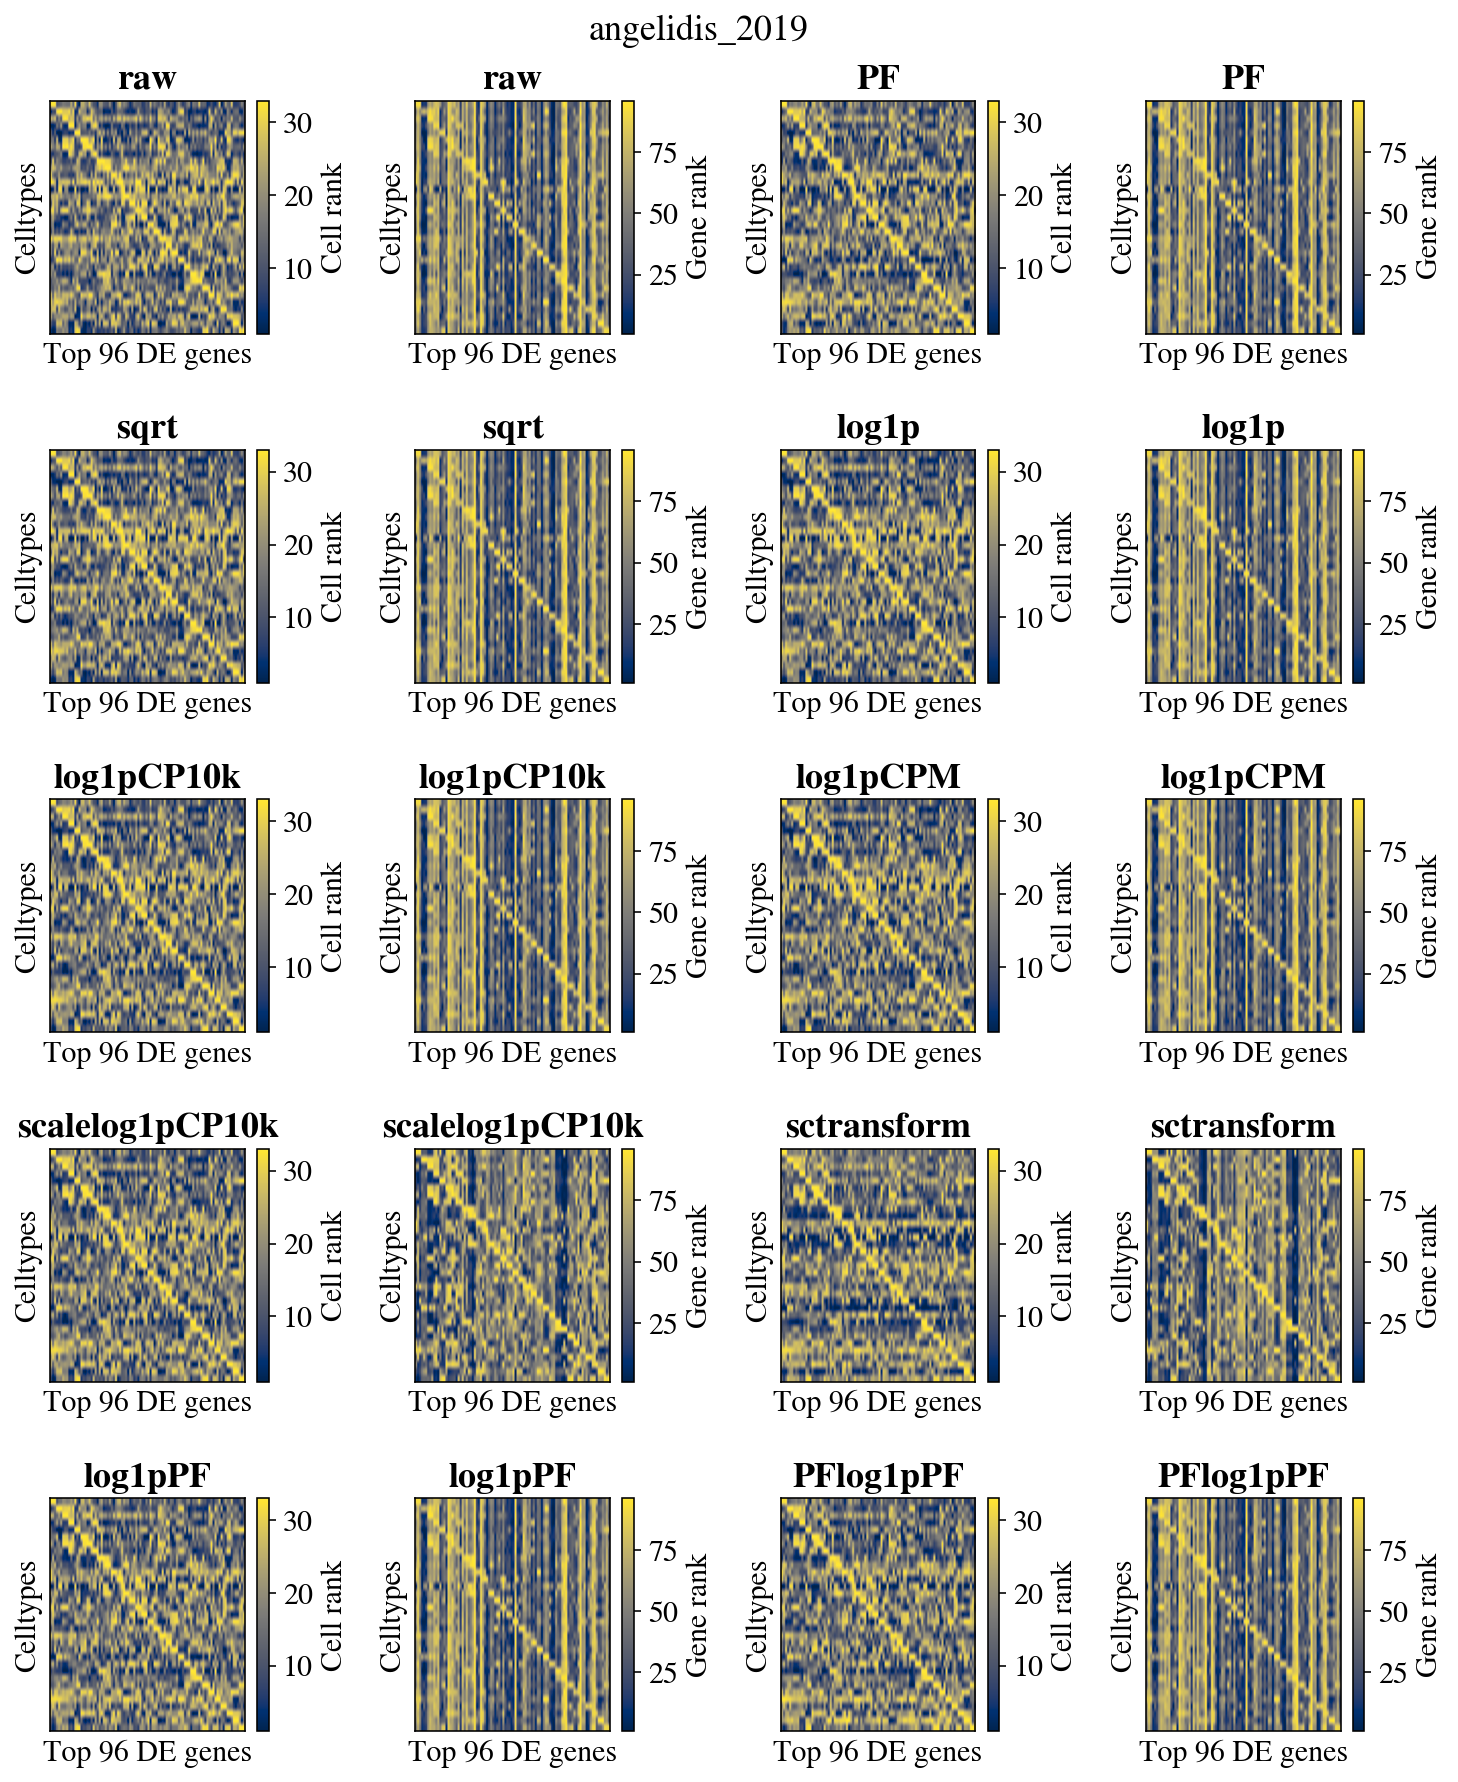

In [18]:
fig = plt.figure(figsize=(4 * 3, 5 * 3))
fig.suptitle(ds, y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.2, hspace=0.5)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i, j].subgridspec(1, 2, wspace=0.5)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        axs.append((ax1, ax2))

mgenes_idx = [list(genes).index(i) for i in mgenes]

p = {
    "ylabel": "Celltypes",
    "xlabel": f"Top {len(mgenes_idx)} DE genes",
    "xticks": [],
    "xticklabels": [],
    "yticks": [],
    "yticklabels": [],
}


clip = 2.5
for (ax1, ax2), title in zip(axs, labels):
    method = title

    # every cell type across all genes
    m = gb[method][:, mgenes_idx]

    # for each gene, make a rank vector
    r1 = stats.rankdata(m, axis=0, method="ordinal")

    # for each cell make a rank vector across genes
    r2 = stats.rankdata(m, axis=1, method="ordinal")

    ## plot
    # genes
    im1 = ax1.imshow(r1, aspect="auto", cmap="cividis")
    ax1.set(**p)
    ax1.set_title(method, weight="bold")
    cbar1 = fig.colorbar(im1, ax=ax1, shrink=1, label="Cell rank")

    # cells
    im2 = ax2.imshow(r2, aspect="auto", cmap="cividis")
    ax2.set(**p)
    ax2.set_title(method, weight="bold")
    cbar2 = fig.colorbar(im2, ax=ax2, shrink=1, label="Gene rank")

# fig.savefig(f"{ds}_heatmap_scale_gene_cell_rank.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

base_file_name = "angelidis_2019-marker_gene_scale_gene_cell_rank-heatmap"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

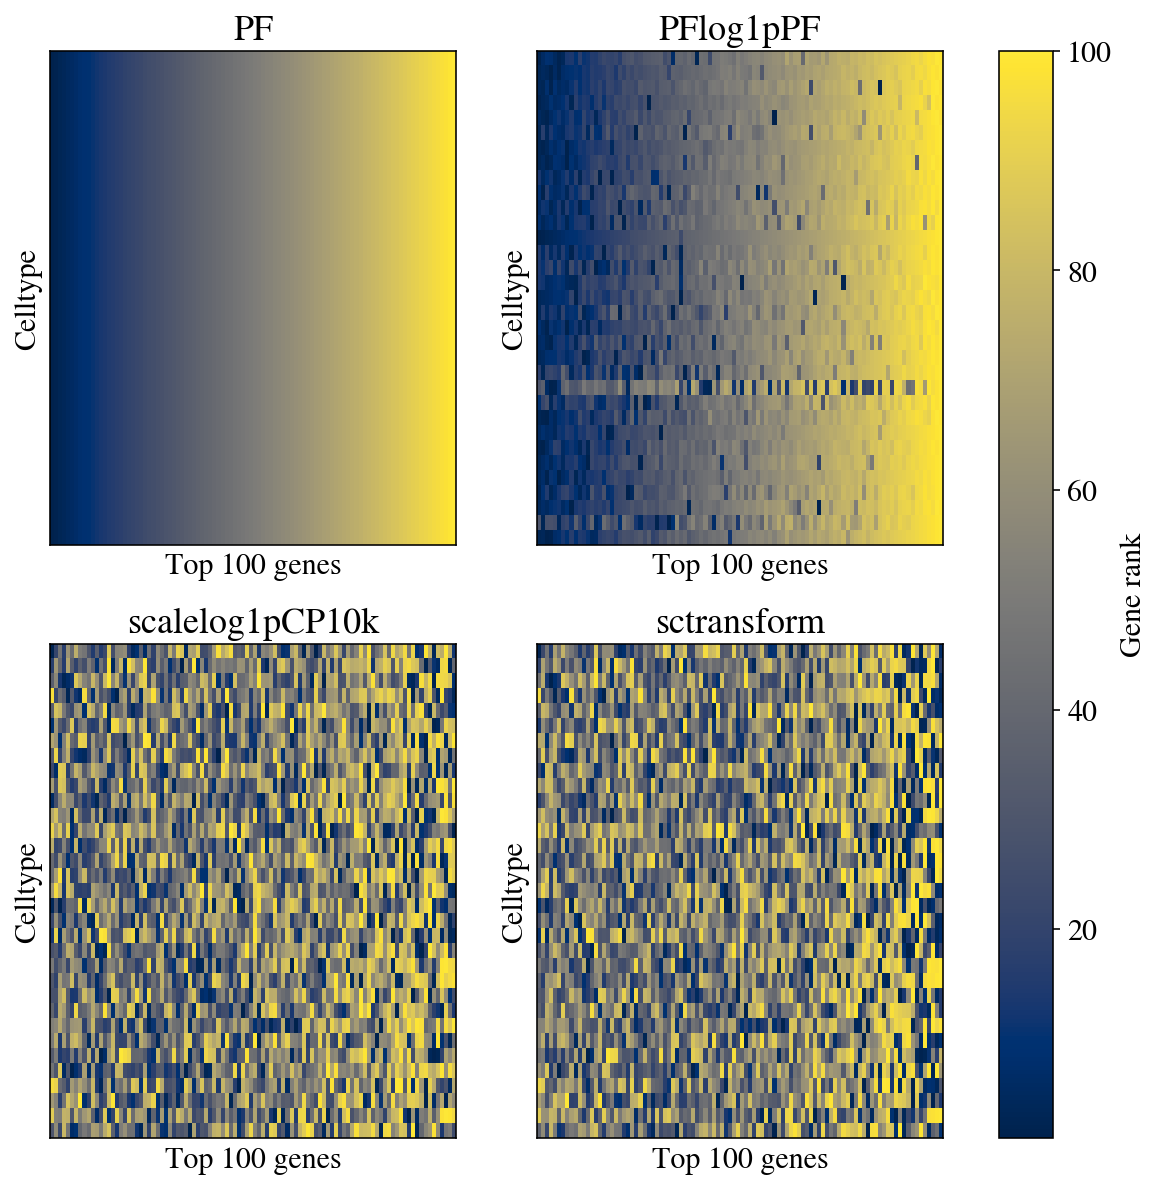

In [19]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr)

nm = 100
ridx = np.argsort(gb["PF"], axis=1)[:, -nm:]

for l, ax in zip(["PF", "PFlog1pPF", "scalelog1pCP10k", "sctransform"], fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method]

    # take top 100 genes (by ranking in raw expression)
    mat = np.take_along_axis(mat, ridx, 1)

    # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")

    im = ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(
        **{
            "ylabel": "Celltype",
            "xlabel": f"Top {nm} genes",
            "xticks": [],
            "xticklabels": [],
            "yticks": [],
            "yticklabels": [],
            "title": method,
        }
    )
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene rank")


base_file_name = "angelidis_2019-top_100_genes_celltype_scramble_monotonicity-heatmap"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

In [20]:
av = {}

# all values

for title in labels:
    print(title)
    df = pd.DataFrame(data[title], index=assignments)
    gg = pd.DataFrame(data[title], index=assignments).sort_index()
    asn = gg.index.values
    av[title] = gg.values

raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc


In [21]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["green", "black", "firebrick"], N=256
)

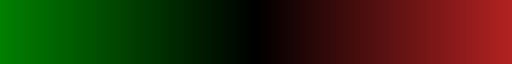

In [22]:
cmap

In [26]:
pltlabels = [
    "raw",
    "PFlog1pPF",
    "scalelog1pCP10k",
    "sctransform",
]

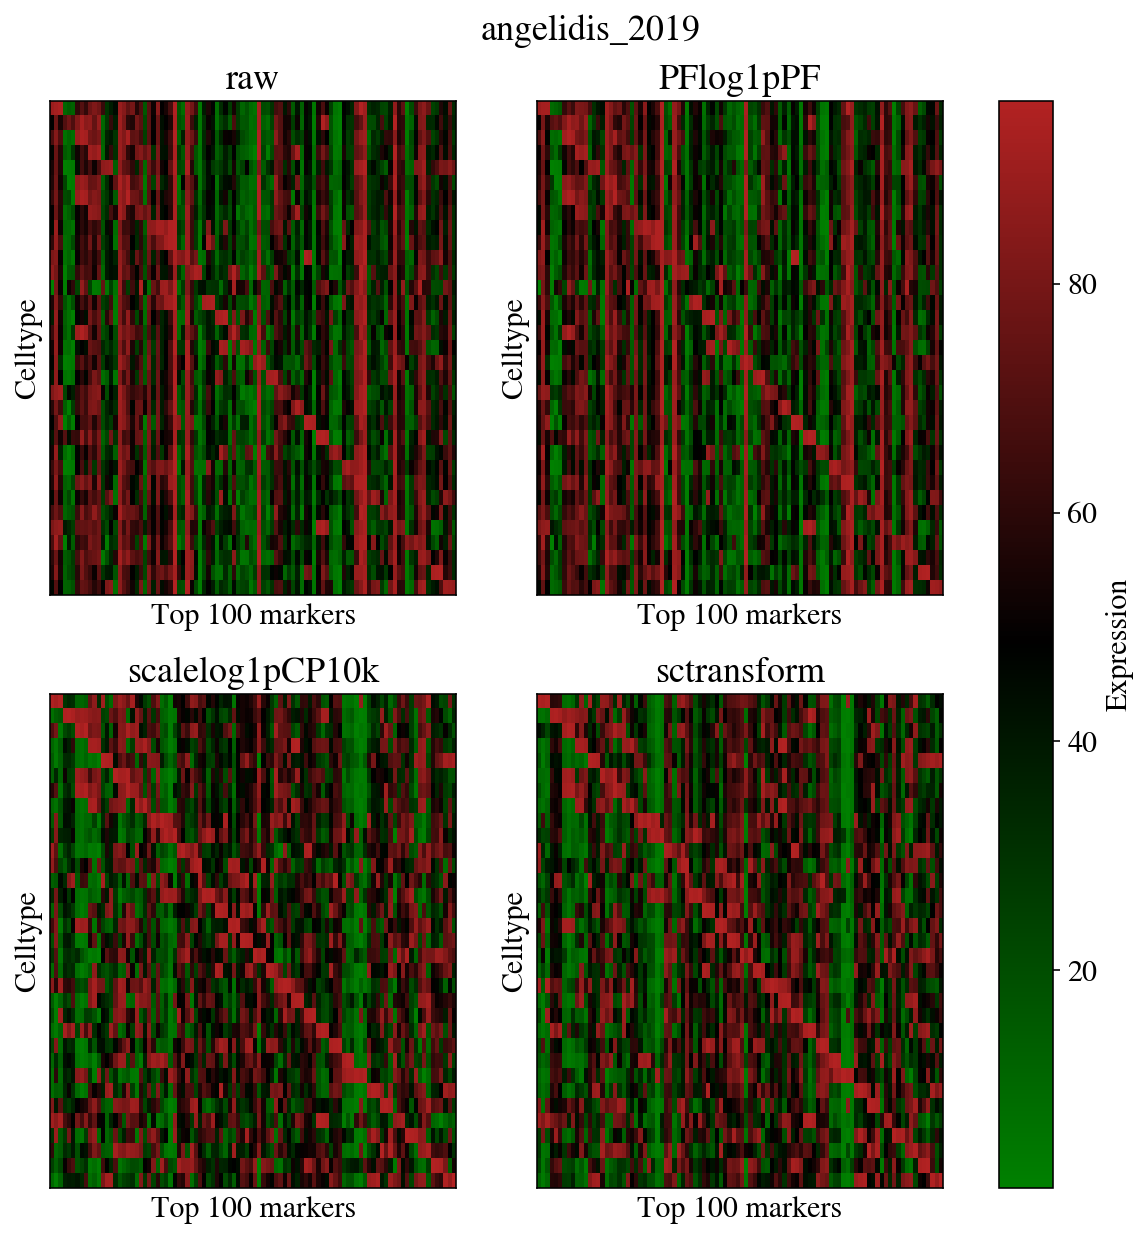

In [27]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr)
fig.suptitle(ds, y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method][:, mgenes_idx]

    #     # take top 100 genes (by ranking in raw expression)
    #     mat = np.take_along_axis(mat, ridx, 1)

    #     # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")

    im = ax.imshow(mat, aspect="auto", cmap=cmap)
    ax.set(
        **{
            "ylabel": "Celltype",
            "xlabel": f"Top {nm} markers",
            "xticks": [],
            "xticklabels": [],
            "yticks": [],
            "yticklabels": [],
            "title": method,
        }
    )

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Expression")

# fig.savefig(f"{ds}_celltype_markergene_rank_collins.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

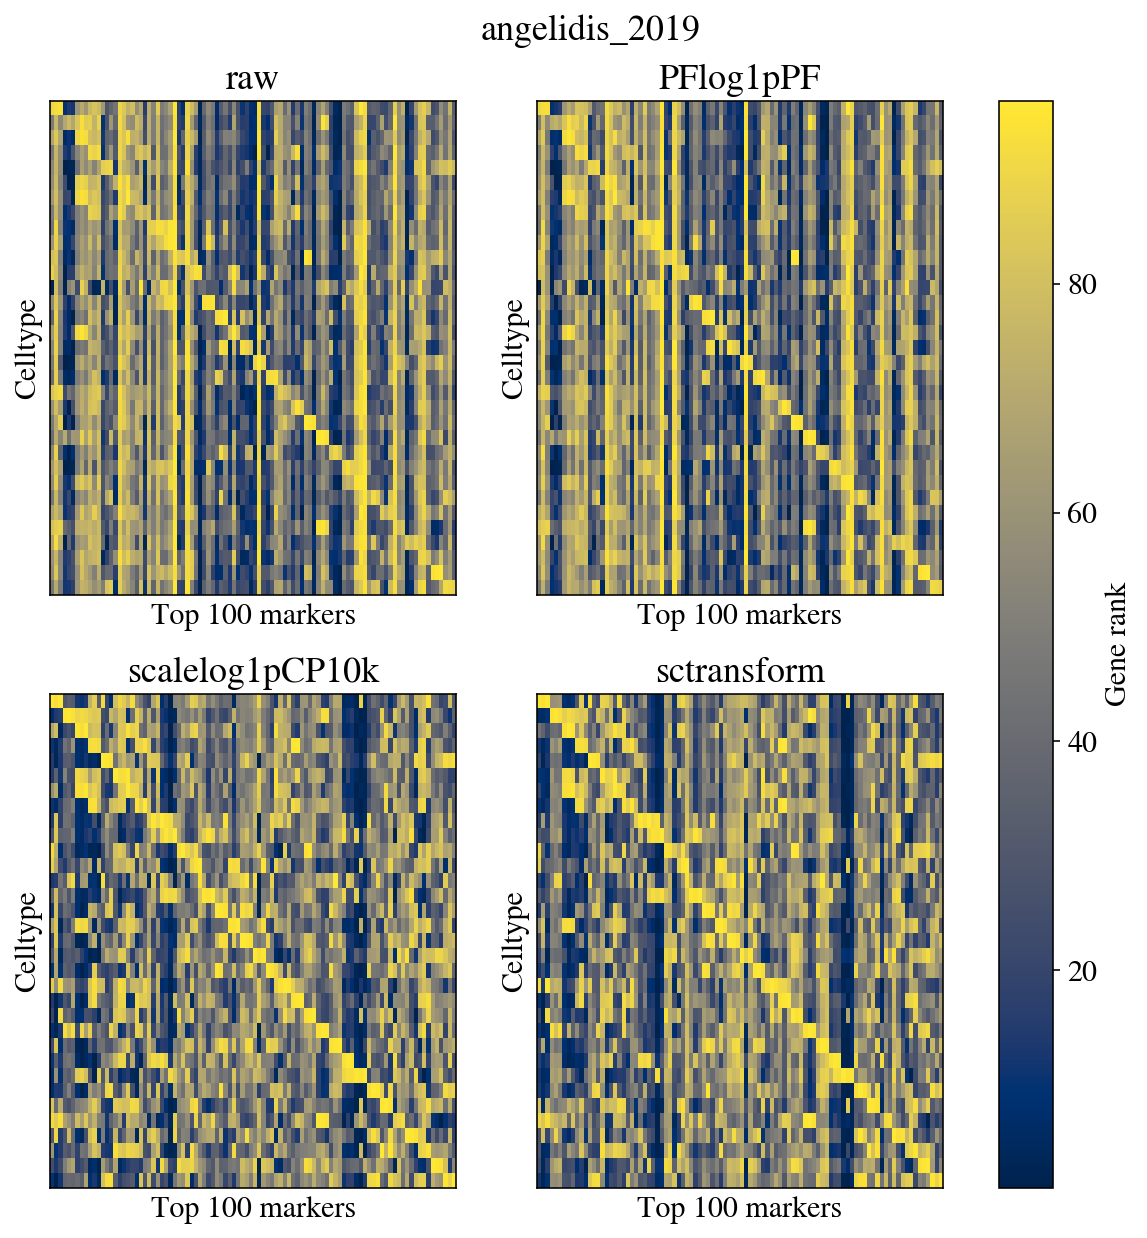

In [28]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr)
fig.suptitle(ds, y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method][:, mgenes_idx]

    #     # take top 100 genes (by ranking in raw expression)
    #     mat = np.take_along_axis(mat, ridx, 1)

    #     # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")

    im = ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(
        **{
            "ylabel": "Celltype",
            "xlabel": f"Top {nm} markers",
            "xticks": [],
            "xticklabels": [],
            "yticks": [],
            "yticklabels": [],
            "title": method,
        }
    )
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene rank")

# fig.savefig(f"{ds}_celltype_markergene_rank.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

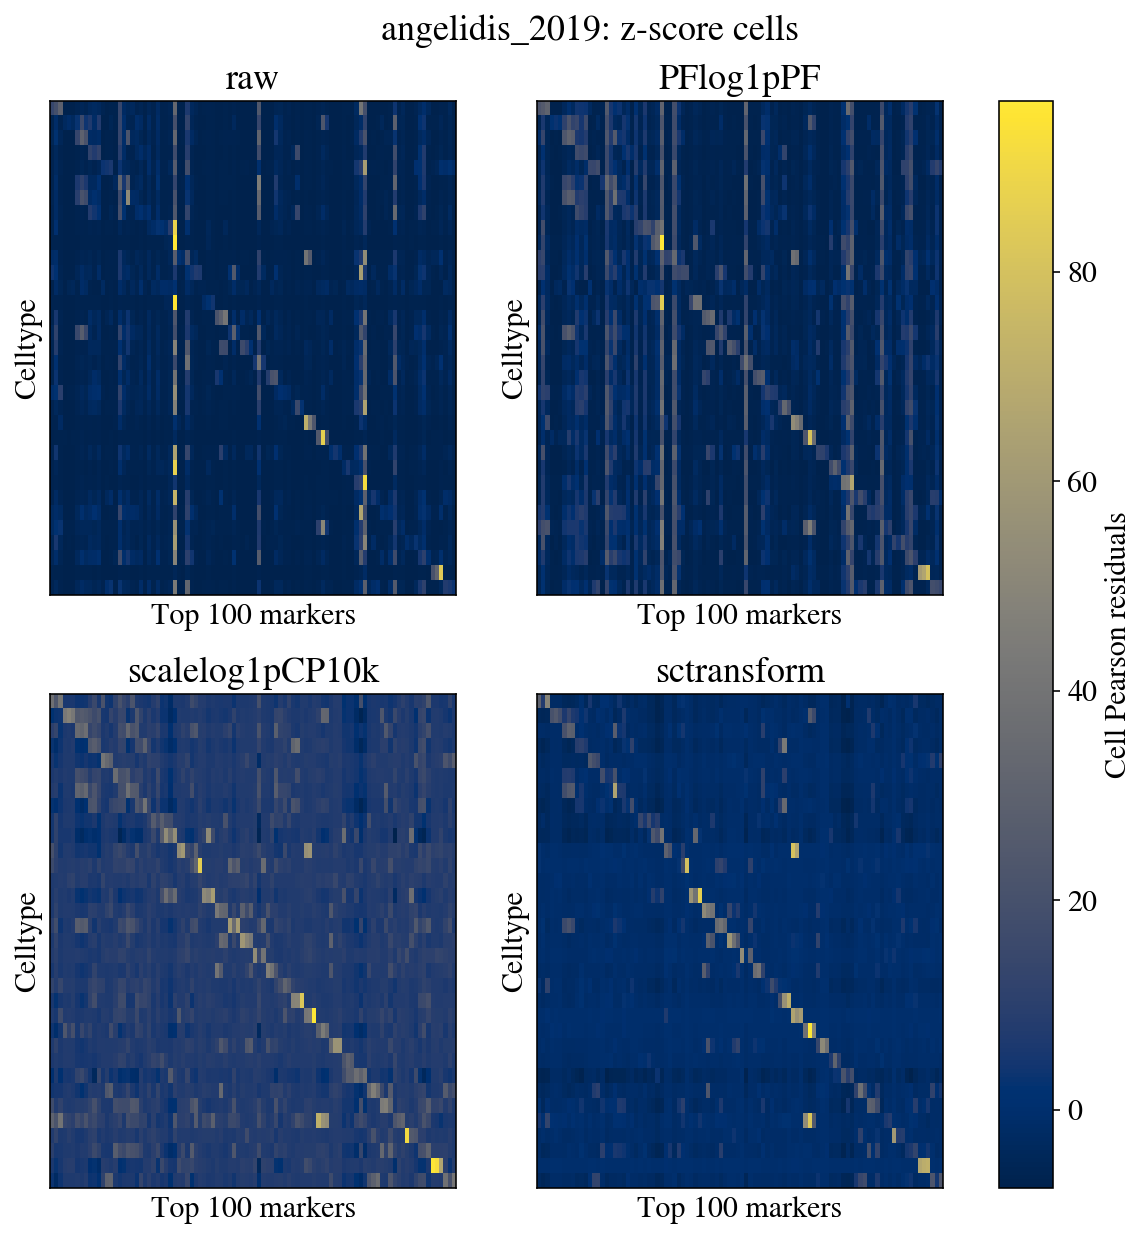

In [29]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr)
fig.suptitle(f"{ds}: z-score cells", y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method]

    # scale genes to zero mean unit variance
    mat = scale(mat, axis=1)

    mat = mat[:, mgenes_idx]

    im = ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(
        **{
            "ylabel": "Celltype",
            "xlabel": f"Top {nm} markers",
            "xticks": [],
            "xticklabels": [],
            "yticks": [],
            "yticklabels": [],
            "title": method,
        }
    )
cbar = fig.colorbar(
    im, ax=axs.ravel().tolist(), shrink=1, label="Cell Pearson residuals"
)

# fig.savefig(f"{ds}_celltype_markergene_rank.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
# when looking at celltypes, you will rank the top genes by "Expression"
# you wont see the top genes being the same with cls or sctransform because the ranking of cells is scrambled
# the top genes could be shared between many celltypes and you dont know whether a gene is highly expressed over all or specific to that celltype

In [32]:
ctd = {}
ct = celltypes[0]
ct_mask = ct_masks[0]

for title in labels:
    df = pd.DataFrame(data[title], index=assignments)
    df = df[ct_mask]
    ctd[title] = df.values

In [33]:
mats = {}
rankmats = {}

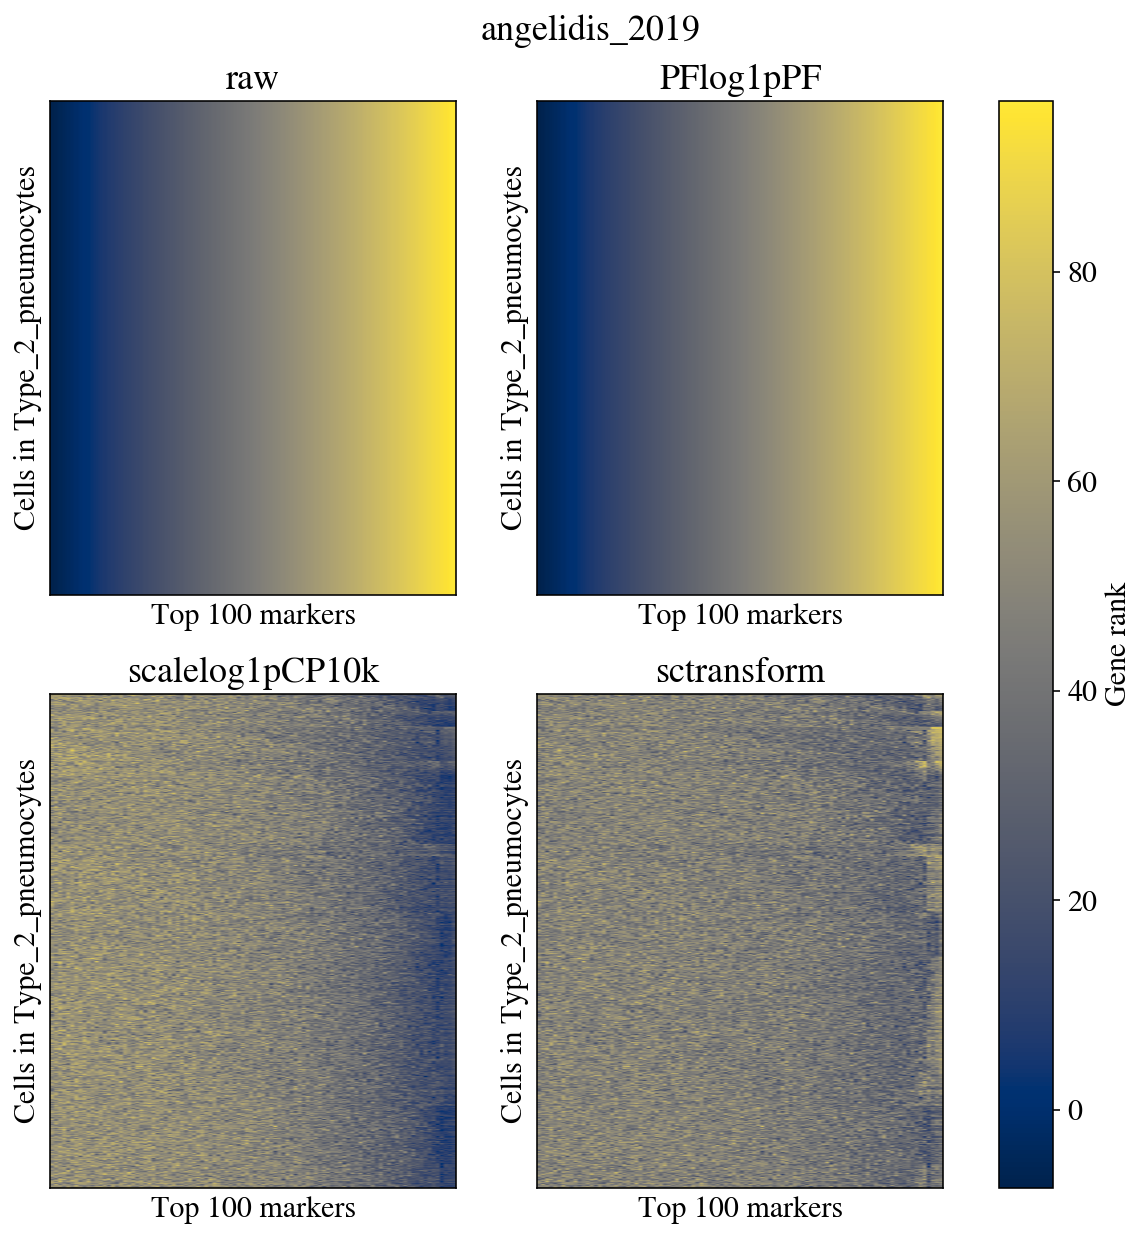

In [34]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr)
fig.suptitle(ds, y=0.94)

nm = 100
ridx = np.argsort(ctd["raw"], axis=1)[:, -nm:]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = ctd[method]

    # take top 100 genes (by ranking in raw expression)
    mat = np.take_along_axis(mat, ridx, 1)
    mats[l] = mat
    # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")
    rankmats[l] = mat

    ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(
        **{
            "ylabel": f"Cells in {ct}",
            "xlabel": f"Top {nm} markers",
            "xticks": [],
            "xticklabels": [],
            "yticks": [],
            "yticklabels": [],
            "title": method,
        }
    )
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene rank")
# fig.savefig(f"{ds}_cell_scramble.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()